<a href="https://colab.research.google.com/github/Bavish2201/Cross-domain-CNN/blob/master/Hyperspectral_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperspectral Image Classification using Cross-domain CNN

## Loading Indian Pines dataset

In [101]:
import numpy as np
import scipy.io
data = scipy.io.loadmat('Indian_pines.mat')['indian_pines']
print(data.shape)

(145, 145, 220)


In [102]:
indian_pines_gt = scipy.io.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
print(indian_pines_gt.shape)

(145, 145)


In [103]:
from scipy.ndimage import rotate

X_indian_pines = []
Y_indian_pines = []

step = 5
x = range(0, 145, step)
y = range(0, 145, step)

for i in x:
  for j in y:
    _data = data[i:i+step, j:j+step]
    X_indian_pines.append(_data)   
    X_indian_pines.append(np.flip(_data, 0))
    X_indian_pines.append(np.flip(_data, 1))
    X_indian_pines.append(rotate(_data, 90))
    X_indian_pines.append(rotate(_data, -90))
     
    label = scipy.stats.mode(indian_pines_gt[i:i+step, j:j+step].reshape(step*step, 1))[0][0][0]
    Y_indian_pines += [label]*5
    
X_indian_pines = np.array(X_indian_pines)
Y_indian_pines = np.array(Y_indian_pines)

print(X_indian_pines.shape)
print(Y_indian_pines.shape)

(4205, 5, 5, 220)
(4205,)


## Salinas Dataset

In [0]:
salinas_data = scipy.io.loadmat('Salinas.mat')['salinas']

In [105]:
print(salinas_data.shape)

(512, 217, 224)


In [106]:
X_salinas = []
step = 5
x = range(0, 510, step)
y = range(0, 215, step)
for i in x:
  for j in y:
    X_salinas.append(salinas_data[i:i+step, j:j+step])
X_salinas = np.array(X_salinas)[:4205]

print(X_salinas.shape)

(4205, 5, 5, 224)


In [107]:
salinas_gt = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']
print(salinas_gt.shape)

(512, 217)


In [0]:
Y_salinas = []
for i in x:
  for j in y:
    label = scipy.stats.mode(salinas_gt[i:i+step, j:j+step].reshape(step*step, 1))[0][0][0]
    Y_salinas.append(label)
Y_salinas = np.array(Y_salinas)

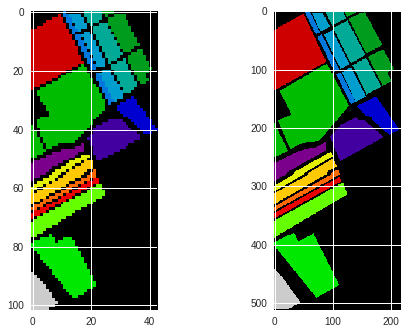

In [109]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
ax[0].imshow(Y_salinas.reshape(102, 43), cmap='nipy_spectral')
ax[1].imshow(salinas_gt, cmap='nipy_spectral')

In [0]:
Y_salinas = Y_salinas[:4205]

from keras.utils import to_categorical
Y_salinas = to_categorical(Y_salinas)
Y_indian_pines = to_categorical(Y_indian_pines)


In [111]:
print(X_indian_pines.shape)
print(Y_indian_pines.shape)
print(X_salinas.shape)
print(Y_salinas.shape)

(4205, 5, 5, 220)
(4205, 17)
(4205, 5, 5, 224)
(4205, 17)


In [0]:
from sklearn.model_selection import train_test_split

(Xtrain_indian_pines, Xtest_indian_pines, Ytrain_indian_pines, Ytest_indian_pines) = train_test_split(X_indian_pines, Y_indian_pines)
(Xtrain_salinas, Xtest_salinas, Ytrain_salinas, Ytest_salinas) = train_test_split(X_salinas, Y_salinas)


## Building the CNN Model

In [0]:
from keras.models import Model
from keras import optimizers
from keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, Input, 
                          concatenate, Add, BatchNormalization, Dropout)


#
# ------- DATASET-SPECIFIC HYPERSPECTRAL ANALYSIS LAYERS
#

# for Indian pines dataset
input1 = Input(shape=(5, 5, 220), name='Indian_Pines_Input')
filter11 = Conv2D(128, (5, 5), activation='relu')(input1)
filter12 = Conv2D(128, (3, 3), activation='relu')(input1)
filter12 = MaxPooling2D((3, 3))(filter12)
filter13 = Conv2D(128, (1, 1), activation='relu')(input1)
filter13 = MaxPooling2D((5, 5))(filter13)
conc1 = concatenate([filter11, filter12, filter13])

# for Salinas dataset
input2 = Input(shape=(5, 5, 224), name='Salinas_Input')
filter21 = Conv2D(128, (5, 5), activation='relu')(input2)
filter22 = Conv2D(128, (3, 3), activation='relu')(input2)
filter22 = MaxPooling2D((3, 3))(filter22)
filter23 = Conv2D(128, (1, 1), activation='relu')(input2)
filter23 = MaxPooling2D((5, 5))(filter23)
conc2 = concatenate([filter21, filter22, filter23])

#
# ---------- SHARED LAYERS ----------------
#

shared_conv1 = Conv2D(128, (1, 1), activation='relu', padding='same')
model1 = shared_conv1(conc1)
model2 = shared_conv1(conc2)

shared_bn1 = BatchNormalization()
model1 = shared_bn1(model1)
model2 = shared_bn1(model2)

shared_conv2 = Conv2D(128, (1, 1), activation='relu', padding='same')
model11 = shared_conv2(model1)
model22 = shared_conv2(model2)

shared_bn2 = BatchNormalization()
model11 = shared_bn2(model11)
model22 = shared_bn2(model22)

shared_conv3 = Conv2D(128, (1, 1), activation='relu', padding='same')
model11 = shared_conv3(model11)
model22 = shared_conv3(model22)

shared_bn3 = BatchNormalization()
model11 = shared_bn3(model11)
model22 = shared_bn3(model22)

shared_add1 = Add()
model1 = shared_add1([model1, model11])
model2 = shared_add1([model2, model22])

shared_conv4 = Conv2D(128, (1, 1), activation='relu', padding='same')
model1 = shared_conv4(model1)
model2 = shared_conv4(model2)

shared_bn4 = BatchNormalization()
model1 = shared_bn4(model1)
model2 = shared_bn4(model2)

shared_conv5 = Conv2D(128, (1, 1), activation='relu', padding='same')
model11 = shared_conv5(model1)
model22 = shared_conv5(model2)

shared_bn5 = BatchNormalization()
model11 = shared_bn5(model11)
model22 = shared_bn5(model22)

shared_conv6 = Conv2D(128, (1, 1), activation='relu', padding='same')
model11 = shared_conv6(model11)
model22 = shared_conv6(model22)

shared_bn6 = BatchNormalization()
model11 = shared_bn6(model11)
model22 = shared_bn6(model22)

shared_add2 = Add()
model1 = shared_add2([model1, model11])
model2 = shared_add2([model2, model22])


#
# -------- DATASET-SPECIFIC CLASSIFICATION LAYERS ------------
#

# for indian pines dataset
model1 = Conv2D(128, (1, 1), activation='relu')(model1)
model1 = BatchNormalization()(model1)

model1 = Conv2D(128, (1, 1), activation='relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dropout(0.1)(model1)

model1 = Conv2D(17, (1, 1), activation='relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dropout(0.1)(model1)

model1 = Flatten()(model1)
model1 = Dense(128, activation='relu')(model1)
model1 = Dense(17, activation='softmax', name='Indian_Pines_Output')(model1)

# for salinas dataset
model2 = Conv2D(128, (1, 1), activation='relu')(model2)
model2 = BatchNormalization()(model2)

model2 = Conv2D(128, (1, 1), activation='relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dropout(0.1)(model2)

model2 = Conv2D(17, (1, 1), activation='relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dropout(0.1)(model2)

model2 = Flatten()(model2)
model2 = Dense(128, activation='relu')(model2)
model2 = Dense(17, activation='softmax', name='Salinas_Output')(model2)

model = Model(inputs=[input1, input2], outputs=[model1, model2])
sgd = optimizers.SGD(lr=0.0001, momentum=0.9, decay=0.0005)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

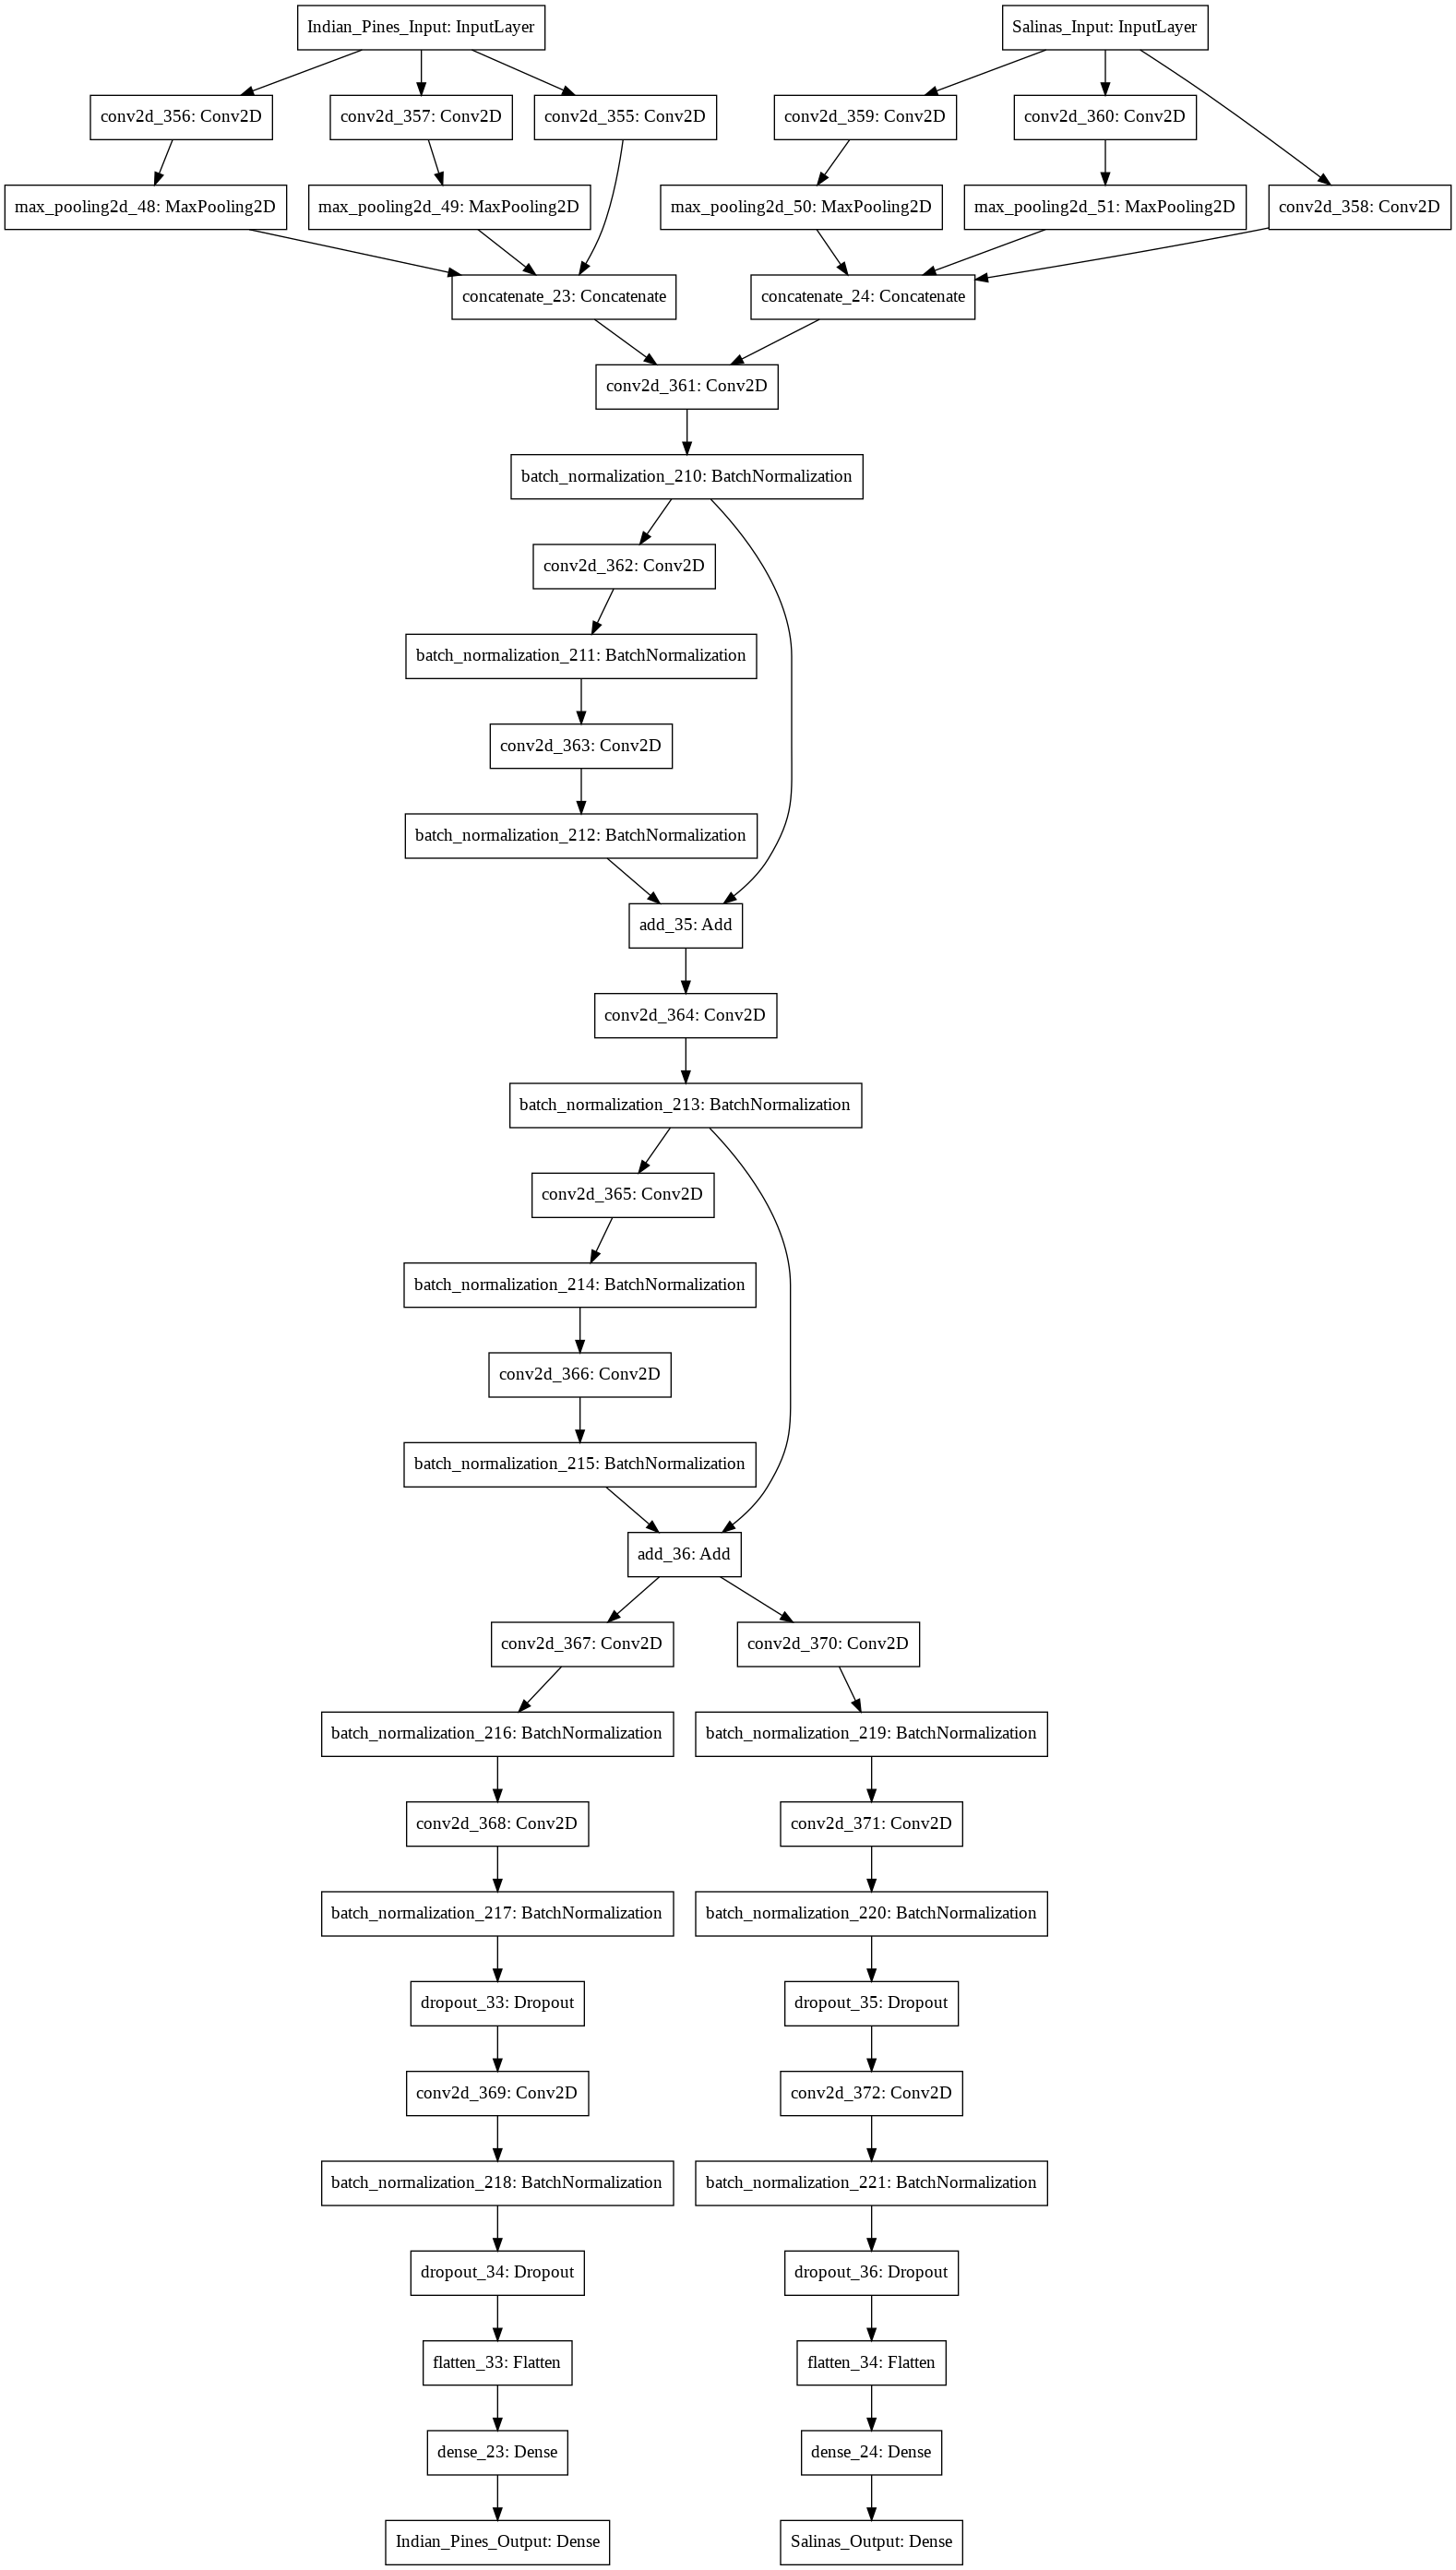

In [145]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from IPython.display import Image, display
display(Image('/content/model.png'))

## Training the model

In [146]:
from keras.callbacks import TensorBoard
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()

tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
history = model.fit({'Indian_Pines_Input': Xtrain_indian_pines, 'Salinas_Input': Xtrain_salinas},
          {'Indian_Pines_Output': Ytrain_indian_pines, 'Salinas_Output': Ytrain_salinas}, epochs=20, callbacks=[TensorBoardColabCallback(tbc)])

Wait for 8 seconds...
TensorBoard link:
http://85ff5a6c.ngrok.io
Epoch 1/20
3153/3153 [==============================] - 8s 2ms/step - loss: 5.6360 - Indian_Pines_Output_loss: 2.7032 - Salinas_Output_loss: 2.9328 - Indian_Pines_Output_acc: 0.0993 - Salinas_Output_acc: 0.0672
Epoch 2/20
3153/3153 [==============================] - 5s 1ms/step - loss: 5.1636 - Indian_Pines_Output_loss: 2.4784 - Salinas_Output_loss: 2.6851 - Indian_Pines_Output_acc: 0.2645 - Salinas_Output_acc: 0.1443
Epoch 3/20
3153/3153 [==============================] - 5s 1ms/step - loss: 4.7669 - Indian_Pines_Output_loss: 2.3185 - Salinas_Output_loss: 2.4484 - Indian_Pines_Output_acc: 0.4152 - Salinas_Output_acc: 0.2988
Epoch 4/20
3153/3153 [==============================] - 5s 1ms/step - loss: 4.4020 - Indian_Pines_Output_loss: 2.1367 - Salinas_Output_loss: 2.2654 - Indian_Pines_Output_acc: 0.5281 - Salinas_Output_acc: 0.4678
Epoch 5/20
3153/3153 [==============================] - 5s 1ms/step - loss: 4.1475 - Indian

### Evaluate the model

In [147]:
results = model.evaluate({'Indian_Pines_Input': Xtest_indian_pines, 'Salinas_Input': Xtest_salinas},
          {'Indian_Pines_Output': Ytest_indian_pines, 'Salinas_Output': Ytest_salinas})
parameters = model.metrics_names
for i in range(5):
  print(parameters[i], results[i])

1052/1052 [==============================] - 8s 8ms/step
loss 9.902867190284875
Indian_Pines_Output_loss 8.089690607310247
Salinas_Output_loss 1.8131765322086928
Indian_Pines_Output_acc 0.4980988596555398
Salinas_Output_acc 0.5969581753582103


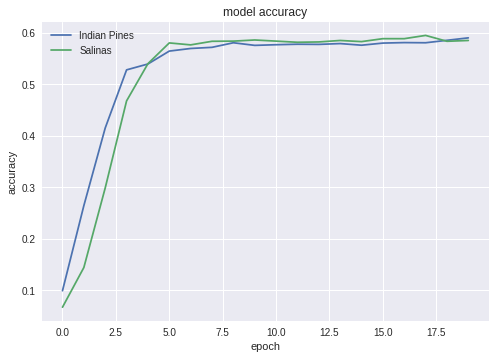

In [148]:
plt.plot(history.history['Indian_Pines_Output_acc'])
plt.plot(history.history['Salinas_Output_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Indian Pines', 'Salinas'], loc='upper left')
plt.show()

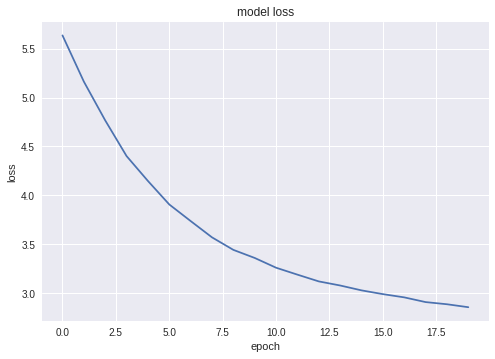

In [149]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()